> Apr 09, 2024 | {sub-ref}`wordcount-minutes` min read


$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\i}{{\color{blue} i}} $ 
$ \newcommand{\Hil}{{\cal H}} $
$ \newcommand{\cg}[1]{{\rm C}#1} $
$ \newcommand{\lp}{\left(} $
$ \newcommand{\rp}{\right)} $
$ \newcommand{\lc}{\left[} $
$ \newcommand{\rc}{\right]} $
$ \newcommand{\lch}{\left\{} $
$ \newcommand{\rch}{\right\}} $
$ \newcommand{\Lp}{\Bigl(} $
$ \newcommand{\Rp}{\Bigr)} $
$ \newcommand{\Lc}{\Bigl[} $
$ \newcommand{\Rc}{\Bigr]} $
$ \newcommand{\Lch}{\Bigl\{} $
$ \newcommand{\Rch}{\Bigr\}} $
$ \newcommand{\rqa}{\quad \Rightarrow \quad} $

# 2. Implementación y ejemplos

In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np
from qiskit_aer import AerSimulator

Para esta implementación se ha seguido la referencia {cite}`bib_FTA_IPE_QSS_Spring_2023_lab3`. Para más información sobre la QPE, ver {cite}`bib_FTA_IPE_QSS_CICC_QPE`

## Fase con expansión binaria exacta

Vamos a ver un par de ejemplo donde la fase que queremos calcular podemos expandirla de forma exacta en forma binaria usando la **notación del punto decimal**. Veremos los dos siguientes casos:

$$
\theta = \frac{1/4} = 0.01 \\
\theta = \frac{1/8} = 0.001
$$

En la sección {ref}`sec_FTA_IPE_fase_no_exacta` vemos el ejemplo con la fase

$$
1/3 = 0.010101\ldots
$$

::::::{admonition} Nota (Notación del punto decimal) 
:class: note



Véase que estamos usando la <b>notación del punto decimal</b>:
 
$$
\frac{1}{4} = 0\cdot2^0 + 0\cdot2^{-1} + 1\cdot2^{-2} = 0.01
$$

Veamos otro ejemplo:

$$
10.101 = 1 \cdot 2^1 + 0 \cdot 2^0 + 1 \cdot 2^{-1} + 0 \cdot 2^{-2} + 1 \cdot 2^{-3} = 2 + \frac{1}{2}+\frac{1}{8}
$$

Debemos tener el cuenta también que multiplicar por 2 implica mover la coma un ligar a la izquierda:
 
$$
2 \cdot 10.101 = 101.01 \\
2^2 \cdot 10.101 = 1010.1
$$
::::::


### Ejemplo 1: con la puerta S

A modo de ejemplo vamos a realizar la IPE en la compuerta $S$ de un solo qubit. La compuerta $S$ viene dada por la matriz

$$ S =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 2}
\end{pmatrix}$$

Usaremos el estado propio $|\psi\rangle = |1\rangle$, que tiene un valor propio $e^{i\pi / 2}= e^{i2\pi \cdot 1/4}$. Entonces tenemos $\theta = 1/4 = 0.01 = 0.\theta_1 \theta_2$. Dado que $\theta$ se puede representar exactamente con 2 bits, nuestra implementación de circuito cuántico utilizará un registro clásico con dos bits para almacenar el resultado.

#### Paso 1

En el primer paso del algoritmo, medimos el bit menos significativo de $\theta$.

:::::{tab-set}
::::{tab-item} Qiskit
```python

def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)
   
    # Inicializacion
    qc.h(qr[0])
    qc.x(qr[1])
    
    qc.cp(np.pi/2, qr[0], qr[1])
    qc.cp(np.pi/2, qr[0], qr[1])    
    
    qc.h(qr[0])
    
    qc.measure(qr[0], cr[0])

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(2, "c")

qc_qk = step_1_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


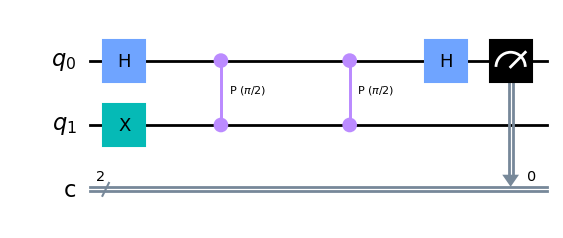

In [2]:
'''Qiskit_code_cell'''

def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)
   
    # Inicializacion
    qc.h(qr[0])
    qc.x(qr[1])
    
    qc.cp(np.pi/2, qr[0], qr[1])
    qc.cp(np.pi/2, qr[0], qr[1])    
    
    qc.h(qr[0])
    
    qc.measure(qr[0], cr[0])

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(2, "c")

qc_qk = step_1_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")

#### Paso 2

En el primer paso, medimos el bit menos significativo $\theta_2$. En el segundo (y último) paso, extraemos el siguiente bit $\theta_1$, que implicará aplicar una corrección de fase para cancelar la contribución de fase de $\theta_2$. La corrección de fase depende del valor del registro clásico que contiene $\theta_2$.

:::::{tab-set}
::::{tab-item} Qiskit
```python
# En Qiskit necesitamos los Dinamic Circuits para realizar esta retroalimentación clásica

def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr)
    
    qc.reset(qr[0])
    
    qc.h(qr[0])
    
    with qc.if_test((cr[0],1)):
        qc.p(-2*np.pi/4, qr[0])
    
    
    qc.cp(np.pi/2, qr[0], qr[1])    
    
    qc.h(qr[0])
    
    qc.measure(qr[0], cr[1])
    

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(2, "c")

qc_qk = step_2_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


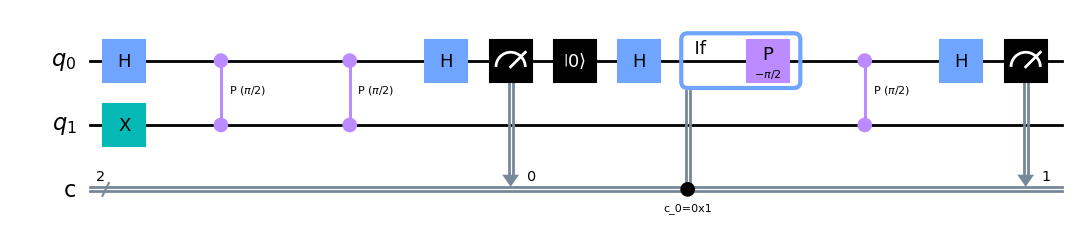

In [4]:
'''Qiskit_code_cell'''
# En Qiskit necesitamos los Dinamic Circuits para realizar esta retroalimentación clásica

def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr)
    
    qc.reset(qr[0])
    
    qc.h(qr[0])
    
    with qc.if_test((cr[0],1)):
        qc.p(-2*np.pi/4, qr[0])
    
    
    qc.cp(np.pi/2, qr[0], qr[1])    
    
    qc.h(qr[0])
    
    qc.measure(qr[0], cr[1])
    

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(2, "c")

qc_qk = step_2_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")

#### Ejecutar la simulación

Vamos a ejecutarlo en un simulador local.

:::::{tab-set}
::::{tab-item} Qiskit
```python
sim_qk = AerSimulator()
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
counts_qk
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


In [5]:
'''Qiskit_code_cell'''
sim_qk = AerSimulator()
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
counts_qk

{'01': 1000}

### Ejemplo 2: con la puerta T

Vamos ahora a contruir el circuito para implementar la IPE para $U=T$:

$$ T =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 4}
\end{pmatrix}$$

:::::{tab-set}
::::{tab-item} Qiskit
```python
def t_gate_ipe_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 3 bits
    
    qc = QuantumCircuit(qr, cr)
    
    qc.x(qr[1])

    for i in range(3):
    
        if i > 0:
            qc.reset(qr[0])
            
        qc.h(qr[0])
        for j in range(i):
            with qc.if_test((cr[j],1)):
                qc.p(-2**(j)*np.pi/2**(i), qr[0])

        for j in range(2**(3-1-i)):
            qc.cp(np.pi/4, qr[0], qr[1]) 
        qc.h(qr[0])
        qc.measure(qr[0], cr[i])
    

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(3, "c")

qc_qk = t_gate_ipe_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


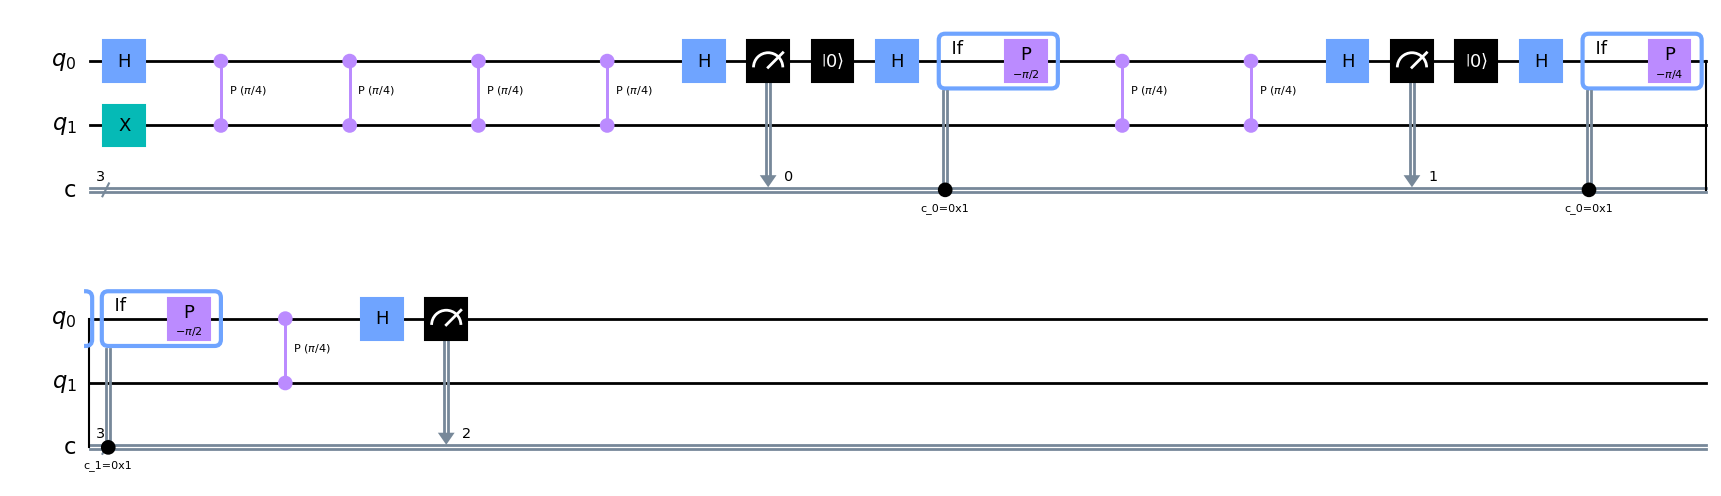

In [6]:
'''Qiskit_code_cell'''
def t_gate_ipe_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 3 bits
    
    qc = QuantumCircuit(qr, cr)
    
    qc.x(qr[1])

    for i in range(3):
    
        if i > 0:
            qc.reset(qr[0])
            
        qc.h(qr[0])
        for j in range(i):
            with qc.if_test((cr[j],1)):
                qc.p(-2**(j)*np.pi/2**(i), qr[0])

        for j in range(2**(3-1-i)):
            qc.cp(np.pi/4, qr[0], qr[1]) 
        qc.h(qr[0])
        qc.measure(qr[0], cr[i])
    

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(3, "c")

qc_qk = t_gate_ipe_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")

Hacemos la simulación:

:::::{tab-set}
::::{tab-item} Qiskit
```python
sim_qk = AerSimulator()
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
counts_qk
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


In [7]:
'''Qiskit_code_cell'''
sim_qk = AerSimulator()
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
counts_qk

{'001': 1000}

(sec_FTA_IPE_fase_no_exacta)= 
## Fase con expansión binaria no exacta

Consideremos el caso cuando la fase no tiene una expansión binaria exacta, por ejemplo, $\varphi = 1/3$.
En este caso, la compuerta de un solo qubit tiene la matriz unitaria

$$ U =
\begin{pmatrix}
1 & 0\\
0 & e^{i2\pi / 3}
\end{pmatrix}
$$

El ángulo $\varphi = 1/3$ no tiene una expansión binaria finita exacta. Por el contrario, tiene la expansión binaria infinita

$$
1/3 = 0.010101\ldots
$$

En la práctica trabajamos con un número fijo de bits de precisión, por lo que nuestro objetivo es obtener el valor más cercano que se pueda representar con esos bits. En el siguiente ejemplo, usaremos dos bits de precisión. En este caso, el valor más cercano es $0.01 = 1/4$. Debido a que este valor no representa la fase exacta, existe cierta probabilidad de que obtengamos un resultado diferente y menos preciso.

:::::{tab-set}
::::{tab-item} Qiskit
```python
def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the first classical bit
    qc.h(q0)
    c0, c1 = cr
    qc.measure(q0, c0)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first classical bit
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the second classical bit
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(2, "c")
qc_qk = QuantumCircuit(qr_qk, cr_qk)
qc_qk = u_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


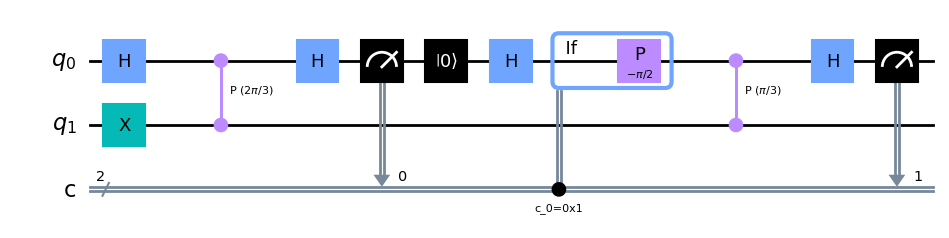

In [8]:
'''Qiskit_code_cell'''
def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the first classical bit
    qc.h(q0)
    c0, c1 = cr
    qc.measure(q0, c0)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first classical bit
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the second classical bit
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(2, "c")
qc_qk = QuantumCircuit(qr_qk, cr_qk)
qc_qk = u_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")

Simulemos

:::::{tab-set}
::::{tab-item} Qiskit
```python
from qiskit_aer import AerSimulator

sim_qk = AerSimulator()
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
print(counts_qk)
success_probability_qk = counts_qk["01"] / counts_qk.shots()
print(f"Success probability: {success_probability_qk}")
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


In [10]:
'''Qiskit_code_cell'''
from qiskit_aer import AerSimulator

sim_qk = AerSimulator()
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
print(counts_qk)
success_probability_qk = counts_qk["01"] / counts_qk.shots()
print(f"Success probability: {success_probability_qk}")

{'11': 60, '10': 59, '00': 196, '01': 685}
Success probability: 0.685


Como puedes ver, esta vez, no tenemos garatía de obtener el resultado deseado. Una pregunta natural es: ¿Cómo podemos aumentar la probabilidad de éxito?

Una forma en que el algoritmo falla es que el primer bit medido es incorrecto. En este caso, la corrección de fase aplicada antes de medir el segundo bit también es incorrecta, lo que hace que el resto de los bits también sean incorrectos. Una forma sencilla de mitigar este problema es repetir la medición de los primeros bits varias veces y obtener un voto mayoritario para aumentar la probabilidad de que midamos el bit correctamente. La implementación de este procedimiento dentro de un solo circuito requiere realizar aritmética en los resultados medidos. Debido a una limitación temporal en Qiskit, actualmente no es posible realizar operaciones aritméticas en bits medidos y condicionar futuras operaciones de circuito en los resultados. Entonces, aquí mediremos cada bit usando circuitos separados.

Las siguientes celdas de código construyen y simulan un circuito IPE para medir solo el primer bit de la fase.

:::::{tab-set}
::::{tab-item} Qiskit
```python
def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 1 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis
    qc.h(q0)
    (c0,) = cr
    qc.measure(q0, c0)

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(1, "c")

qc_qk = u_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


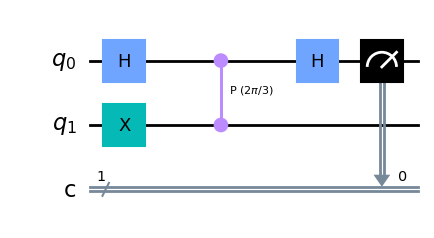

In [11]:
'''Qiskit_code_cell'''
def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 1 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis
    qc.h(q0)
    (c0,) = cr
    qc.measure(q0, c0)

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(1, "c")

qc_qk = u_circuit(qr_qk, cr_qk)
qc_qk.draw("mpl")

Simulemos

:::::{tab-set}
::::{tab-item} Qiskit
```python
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
print(counts_qk)
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


In [13]:
'''Qiskit_code_cell'''
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
print(counts_qk)

{'0': 243, '1': 757}


Con suerte, el bit correcto se midió la mayoría de las veces. Veamos cual fue el más medido:

:::::{tab-set}
::::{tab-item} Qiskit
```python

keys_qk   = counts_qk.keys()
values_qk = counts_qk.values()

zip_list_qk = zip(keys_qk, values_qk)
zip_sorted_qk = list(sorted(zip_list_qk, key = lambda x: -x[1]))
keys_qk, values_qk = zip(*list(zip_sorted_qk))

step1_bit_qk = eval(keys_qk[0])

print(step1_bit_qk)
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


In [15]:
'''Qiskit_code_cell'''

keys_qk   = counts_qk.keys()
values_qk = counts_qk.values()

zip_list_qk = zip(keys_qk, values_qk)
zip_sorted_qk = list(sorted(zip_list_qk, key = lambda x: -x[1]))
keys_qk, values_qk = zip(*list(zip_sorted_qk))

step1_bit_qk = eval(keys_qk[0])

print(step1_bit_qk)

1


Ahora construyamos el circuito para medir el segundo bit de la fase. Reemplazemos la primera etapa del circuito con una que simplemente establezca el bit auxiliar en el valor que medimos anteriormente, de modo que siempre midamos el valor correcto para el primer bit de la fase.

:::::{tab-set}
::::{tab-item} Qiskit
```python
def u_circuit(qr: QuantumRegister, cr: ClassicalRegister, step1_bit : int) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)
    
    if step1_bit == 1:
        qc.x(qr[0])
        qc.measure(qr[0], cr[0])
        qc.x(qr[0])
    else:
        qc.measure(qr[0], cr[0])

    
    qc.h(qr[0])
    qc.x(qr[1])

    with qc.if_test((cr[0], 1)):
        qc.p(-np.pi/2, qr[0])
        
    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, qr[0], qr[1])

    # Measure the auxiliary qubit in x-basis
    qc.h(qr[0])
    qc.measure(qr[0], cr[1])

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(2, "c")

qc_qk = u_circuit(qr_qk, cr_qk, step1_bit_qk)
qc_qk.draw("mpl")
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


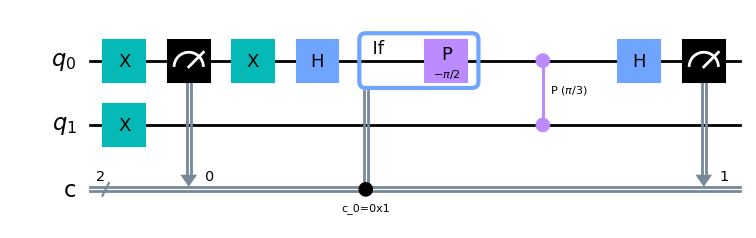

In [17]:
'''Qiskit_code_cell'''
def u_circuit(qr: QuantumRegister, cr: ClassicalRegister, step1_bit : int) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)
    
    if step1_bit == 1:
        qc.x(qr[0])
        qc.measure(qr[0], cr[0])
        qc.x(qr[0])
    else:
        qc.measure(qr[0], cr[0])

    
    qc.h(qr[0])
    qc.x(qr[1])

    with qc.if_test((cr[0], 1)):
        qc.p(-np.pi/2, qr[0])
        
    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, qr[0], qr[1])

    # Measure the auxiliary qubit in x-basis
    qc.h(qr[0])
    qc.measure(qr[0], cr[1])

    return qc


qr_qk = QuantumRegister(2, "q")
cr_qk = ClassicalRegister(2, "c")

qc_qk = u_circuit(qr_qk, cr_qk, step1_bit_qk)
qc_qk.draw("mpl")

Simulemos

:::::{tab-set}
::::{tab-item} Qiskit
```python
sim_qk = AerSimulator()
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
print(counts_qk)
success_probability_qk = counts_qk["01"] / counts_qk.shots()
print(f"Success probability: {success_probability_qk}")
```
::::
::::{tab-item} Qibo
```python

```
::::
:::::


In [18]:
'''Qiskit_code_cell'''
sim_qk = AerSimulator()
job_qk = sim_qk.run(qc_qk, shots=1000)
result_qk = job_qk.result()
counts_qk = result_qk.get_counts()
print(counts_qk)
success_probability_qk = counts_qk["01"] / counts_qk.shots()
print(f"Success probability: {success_probability_qk}")

{'11': 58, '01': 942}
Success probability: 0.942


::::::{admonition} Nota (Precisión) 
:class: note



Vemos que el resultado sigue sin ser muy bueno, pero es el que esperabamos $1/4$. Podemos mejorar la precisión de este valor aumentando el número de qúbit que usamos, de dos a tres, cuatro,...
::::::


---
## Bibliografía 
```{bibliography} 
:style: plain
:filter: docname in docnames
```

---
Autores:

David Castaño ([UMA-SCBI](https://www.scbi.uma.es/site/)), Raul Fuentes ([BSC-CNS](https://www.bsc.es/es)), Daniel Talaván  ([Cenits](https://www.cenits.es/)), Francisco Matanza ([UNICAN](https://web.unican.es/))

<img src="images/Logo_UMA.jpeg"  width="180px"> 
<img src="images/BSC-blue-medium.png" width="180px">
<img src="images/xaniversario_rectangle.jpg" width="180px">
<img src="images/Logo_UNICAM.jpg" width="180px">

---
::::{figure} https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png
:width: 2000px
:align: center
::::

<center>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
<img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
</center>

License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Licencia Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

This work has been financially supported by the Ministry for Digital Transformation and of Civil Service of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2026 Agenda.

<center>
<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2024/02/Banner-QS_GOB_v2.png" width="1000px" />
</center>